### Ex3.7：Local histogram equalization
Compute the gray level (luminance) histograms for each patch, but add to vertices based on distance (a spline)

In [1]:
# import 
import cv2
import matplotlib.pyplot as plt
import numpy as np
import copy

In [2]:
# draw function:
def plt_show(title,img,cmap = None):
    fig = plt.figure()
    plt.imshow(img,cmap = cmap)
    plt.title(title)
    plt.show()

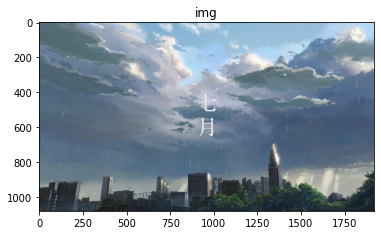

In [3]:
# load img:
img_name = "trim.jpg"
img = cv2.imread(img_name)

# color img:
img_color = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt_show("img",img_color)

#### Q1: Build on Exercise 3.6 (luminance computation).
i.e. convert the color image to luminance and compute the histogram.
- way1: <br>
apply `cv2.COLOR_BGR2GRAY`
- way2: <br>
`luminance Y' = 0.299R'+0.587G'+0.114B'` (2.112) <br>
where Y' is gamma compressed.

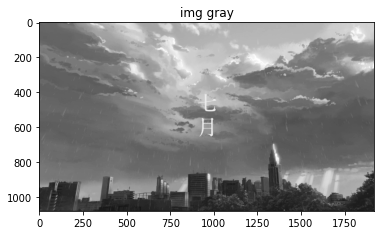

In [4]:
# convert the color image to luminance
# way1:
img_gray_1 = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt_show("img gray",img_gray_1,"gray")

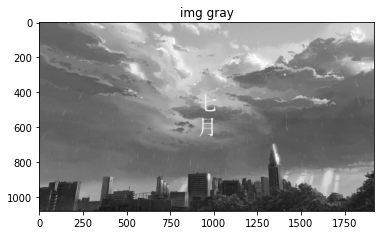

In [5]:
# convert the color image to luminance
# way2:
B,G,R = img[:,:,0].astype('int'),img[:,:,1].astype('int'),img[:,:,2].astype('int')
img_gray_2 = 0.299*R+0.587*G+0.114*B
img_gray_2[img_gray_2>255] = 255
img_gray_2 = img_gray_2.astype('uint8')
plt_show("img gray",img_gray_2,"gray")

In [6]:
# differences:
print("Differences between two ways:")
print(abs(img_gray_2.astype('int') -img_gray_1.astype('int')))
print("gap > 1:")
print(np.where(abs(img_gray_2.astype('int') -img_gray_1.astype('int')>1)))

Differences between two ways:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
gap > 1:
(array([], dtype=int64), array([], dtype=int64))


It seems that there is no distinct gaps between the two results.<br>
So I choose the first method to convert color img to luminance randomly.

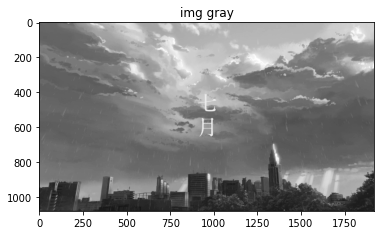

In [7]:
# select cv2.COLOR_BGR2GRAY
img_gray = img_gray_1
plt_show("img gray",img_gray,cmap="gray")

##### Histogram:
To measure a histogram:<br>
For B-bit image, initialize 2^B counters with 0. In this case, we use `2^8 = 256` counters. <br>
Loop over all pixels x,y <br>
When encountering gray level `f[x,y]=i`, increment counter. 

In [8]:
# Compute Histogram:
def Histogram(img_gray):
    hist = np.zeros((1,256),dtype='int')
    for i in range(img_gray.shape[0]):
        for j in range(img_gray.shape[1]):
            hist[0,img_gray[i][j]]+=1
    return hist

In [9]:
hist = Histogram(img_gray) # shape = (1,256)

Text(0, 0.5, 'pixels')

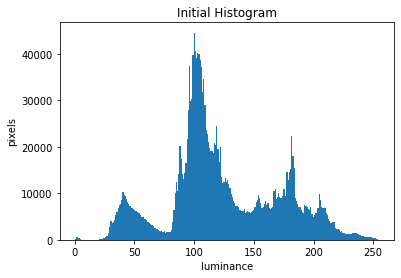

In [10]:
_ = plt.hist(img_gray.ravel(),256)
plt.title("Initial Histogram")
plt.xlabel("luminance")
plt.ylabel("pixels")

#### Q2: Distribute values(counts) to adjacent vertices(bilinear).
idea：we can distribute each input pixel into four adjacent look up tables during the histogram accumulations phase<br>
i.e. `h(I(i,j)) += w(i,j,k,l)`<br>
where `w(i,j,k,l)` is the bilinear weighting function between pixel (i,j) and look up table (k,l)

##### Compute Vertices' positions:
- since the img that I read is `1080*1920`, I choose to divide it into `3*5`.<br>
So the size of each block is `360*384`
- Positions of every vertice in this img are shown and highlightd in the img.
```
vertice_X = [   0,  359,  719, 1079]
vertice_Y = [   0,  383,  767, 1151, 1535, 1919]
``` 

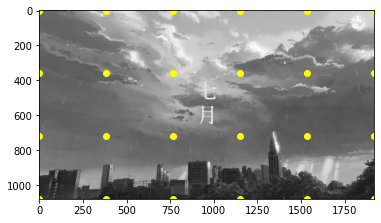

In [11]:
# Vertices' positions Computation:
block_num = (3,5) # shape = (1080,1920)
# vertices position:
x = np.linspace(0,img.shape[0]-1,block_num[0]+1).astype('int')
y = np.linspace(0,img.shape[1]-1,block_num[1]+1).astype('int')
X,Y = np.meshgrid(x,y)
X_boudary = X[0]
Y_boudary = Y[:,0]
window_size = (img.shape[0]//block_num[0],img.shape[1]//block_num[1])
plt.imshow(img_gray,cmap="gray")
plt.scatter(Y,X,c="yellow")
plt.show()

##### Distribute values:
- Every vertice will form a histogram while recording the luminance of pixels in the block where it belongs.<br>
function **vertice_init()** will initialize bins for each vertices.
---
- Soft histogramming:<br>
Instead of adding a point to a single histogram bin, it adds points to the adjacent bins **weighted by the distance** from the bin center.<br>
**Start from 1-D:** if a point falls on the boundary between two bins, we can add `0.5` to each of the two bins.<br>
If it's `70%` of the way between the center of the first bin and the center of the second one, we can add `0.3` to the first bin and `0.7` to the second bin.<br>
In this case, we should use **2-D**:<br>
`w(i,j,k,l) = (1-s)(1-t) or s(1-t) or (1-s)t or st`, where `s,t` are the 1-D forms indicating the distance between the `pixel (i,j)` and the `vertice (k,l)` in both **horizontal and vertical** directions.




In [12]:
# init bins for each vertices:
def vertice_init():
    vertice_pos = []
    vertice_bins = []
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            vertice_pos.append((X[i][j],Y[i][j]))
            vertice_bins.append(np.zeros((1,256)))
    vertice_hist = dict(zip(vertice_pos,vertice_bins))
    return vertice_hist

In [13]:
# distribute function:
def distribute_fun(img_gray,vertice_hist):
    for i in range(0,img_gray.shape[0]):
        for j in range(0,img_gray.shape[1]):
            index_i = i//window_size[0]
            index_j = j//window_size[1]
            # 左上角的坐标
            upleft_x = X_boudary[index_i]
            upleft_y = Y_boudary[index_j]
            # 右上角坐标：
            upright_x = X_boudary[index_i+1]
            # 左下角坐标：
            downleft_y = Y_boudary[index_j+1]

            # s,t computed：
            s,t = 0,0
            s = abs((i-upleft_x)/ (upright_x-upleft_x))
            t = abs((j-upleft_y)/(downleft_y-upleft_y))

            # distribute value to vertical:
            luma = img_gray[i,j]
            # upleft: (1-s)*(1-t)
            vertice_hist.get((upleft_x,upleft_y))[0,luma]+=(1-s)*(1-t)
            # upright:s*(1-t)
            vertice_hist.get((upright_x,upleft_y))[0,luma]+=s*(1-t)
            # downleft:(1-s)*t
            vertice_hist.get((upleft_x,downleft_y))[0,luma]+=(1-s)*t
            # downright:s*t
            vertice_hist.get((upright_x,downleft_y))[0,luma]+=s*t
    return vertice_hist

In [14]:
# distribute:
vertice_hist = vertice_init()
vertice_hist = distribute_fun(img_gray,vertice_hist)

We can draw the histogram of every corner and calculate the sum of histograms.<br>
It's easy to find that the sum will equal to the amount of pixels in the img, which in this case is 1080*1920 = 2073600

(0, 0)


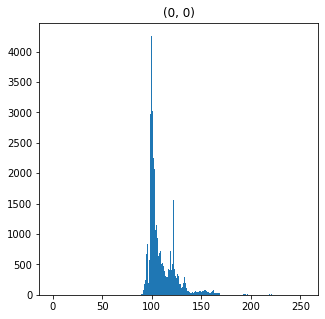

(359, 0)


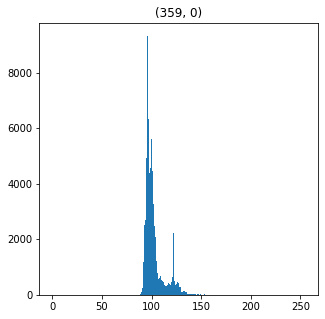

(719, 0)


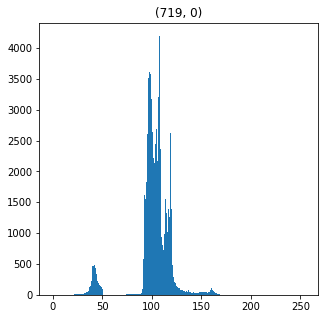

(1079, 0)


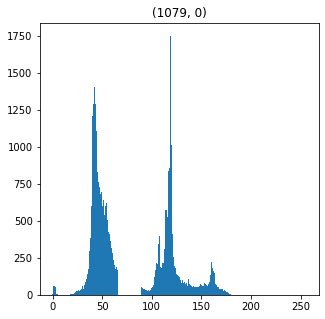

(0, 383)


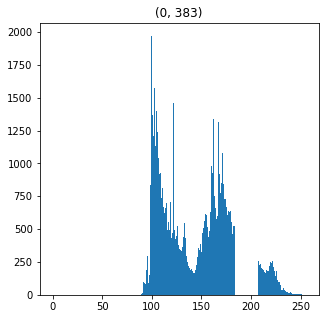

(359, 383)


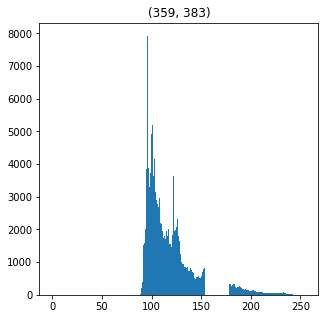

(719, 383)


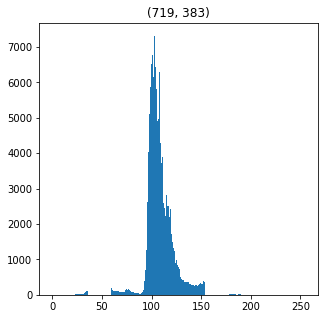

(1079, 383)


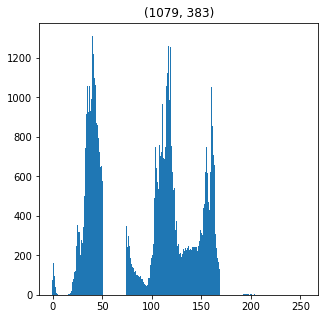

(0, 767)


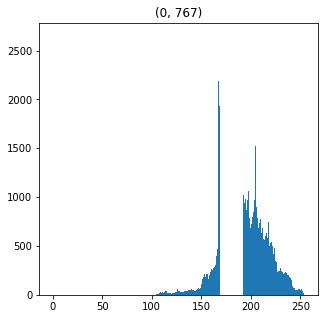

(359, 767)


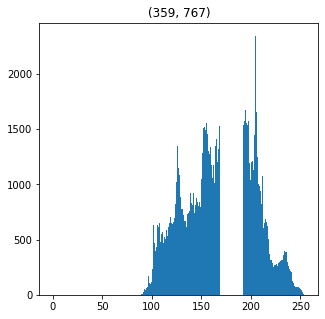

(719, 767)


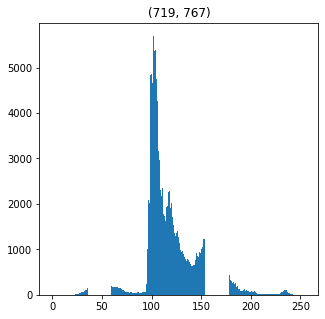

(1079, 767)


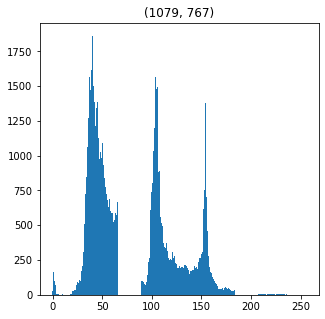

(0, 1151)


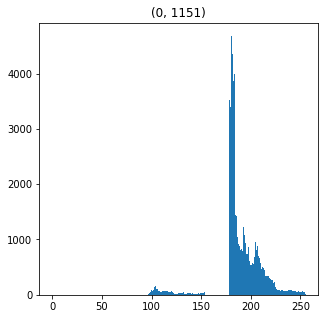

(359, 1151)


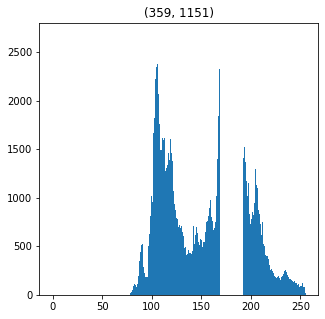

(719, 1151)


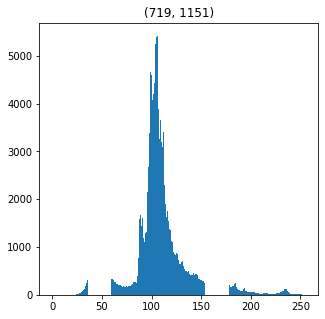

(1079, 1151)


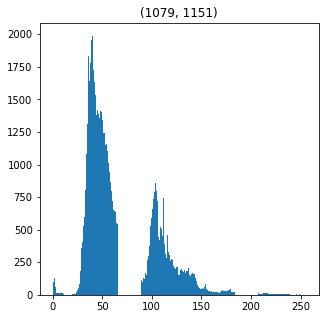

(0, 1535)


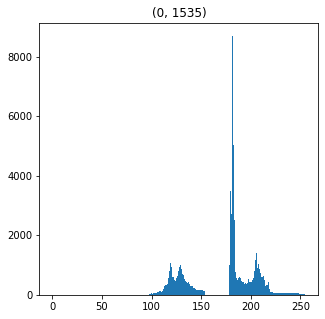

(359, 1535)


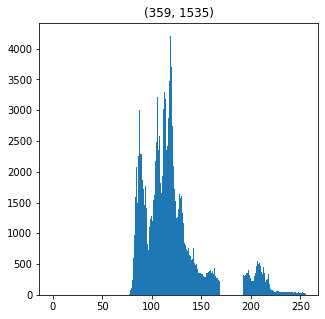

(719, 1535)


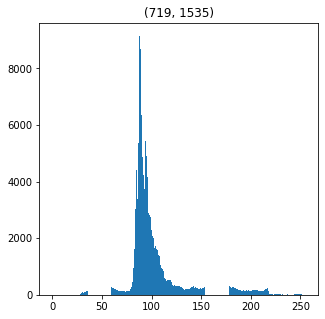

(1079, 1535)


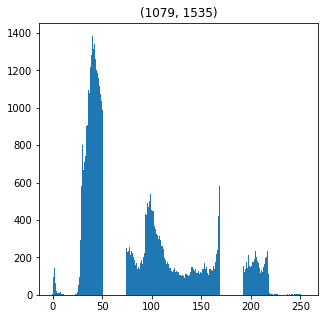

(0, 1919)


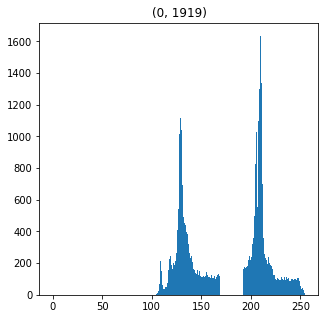

(359, 1919)


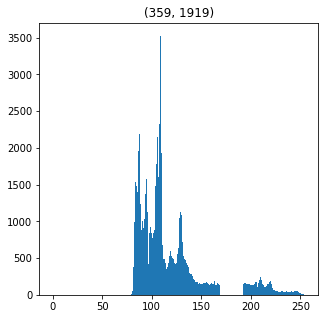

(719, 1919)


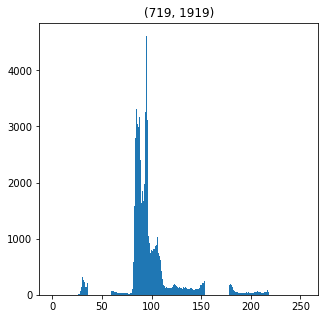

(1079, 1919)


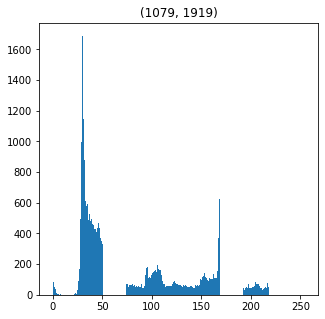

2073600.0000000002


In [15]:
# show:
sum = 0
for key,value in vertice_hist.items():
    print(key)
    fig = plt.figure(figsize=(5,5))
    plt.bar(x = np.arange(0,256,1),height=value[0])
    plt.title(str(key))
    plt.show()
    sum+=np.sum(value[0])
print(sum)

#### Q3: Convert to CDF (look-up functions)
i.e. Convert the histogram in each corner to CDF.
- function `CDF(hist)` will compute CDF from a histogram
- function `block_cdf_fun(vertice_hist)` will compute each corner's histogram with function `CDF(hist)`

In [16]:
# Compute CDF
def CDF(hist):
    sum = np.sum(hist)
    cdf = []
    for i in range(0,256):
        cdf.append(np.sum(hist[0:i])/sum)
    return np.array(cdf)

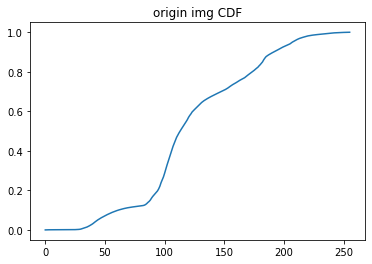

In [17]:
# origin img gray cdf:
origin_cdf = CDF(hist[0])
# show:
plt.plot(np.arange(0,256,1),origin_cdf)
plt.title("origin img CDF")
plt.show()

In [18]:
# Compute Vertice_cdf and Rescale to 0-255
def block_cdf_fun(vertice_hist):
    vertice_cdf = []
    for key,value in vertice_hist.items():
        cdf = CDF(value[0])
        cdf_r = (np.array((cdf))*255.0).astype('uint8')
        vertice_cdf.append(cdf_r) 
    vertice_cdf = dict(zip(vertice_hist.keys(),vertice_cdf))
    return vertice_cdf

In [19]:
vertice_cdf = block_cdf_fun(vertice_hist)

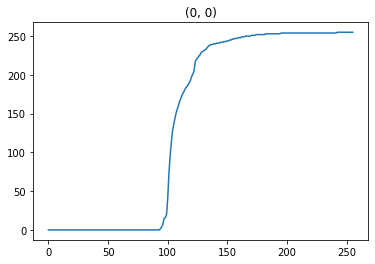

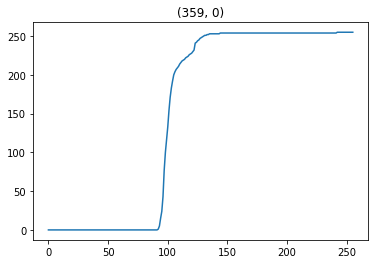

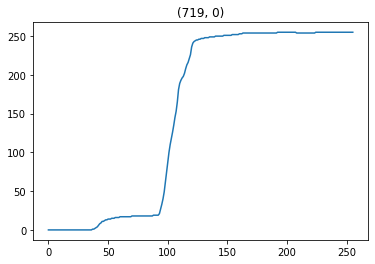

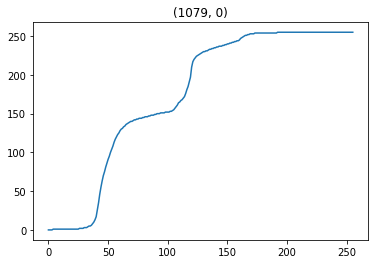

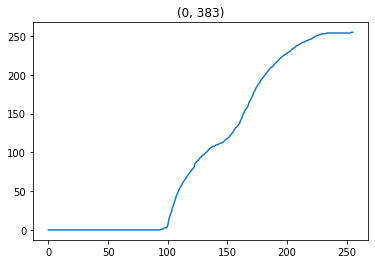

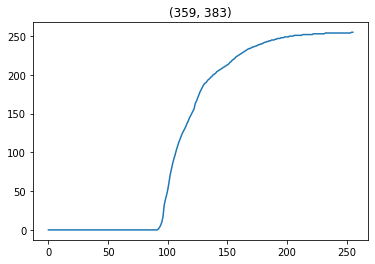

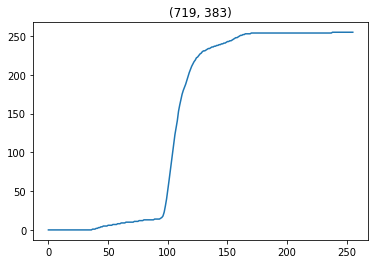

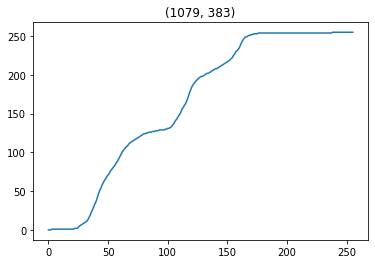

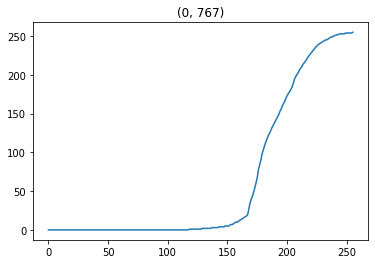

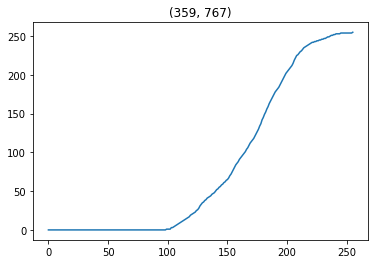

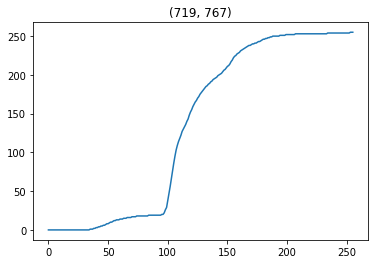

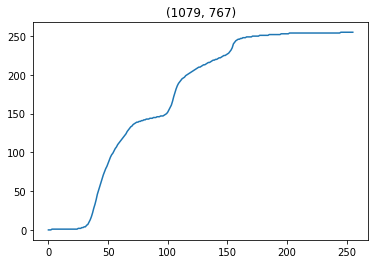

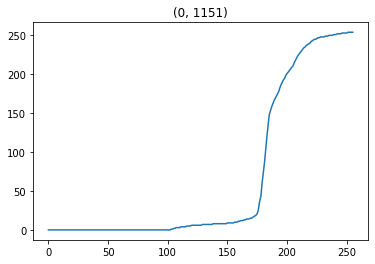

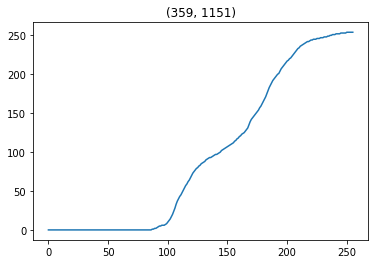

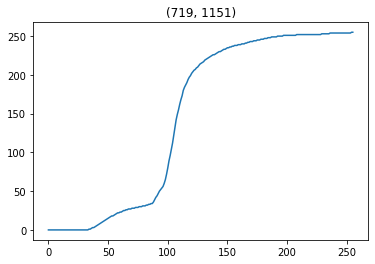

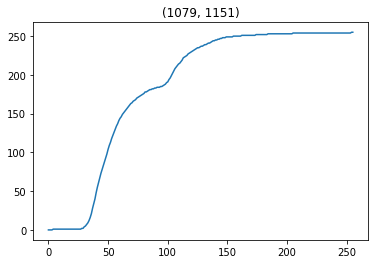

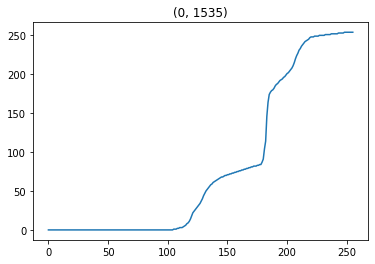

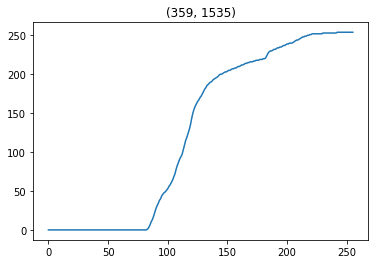

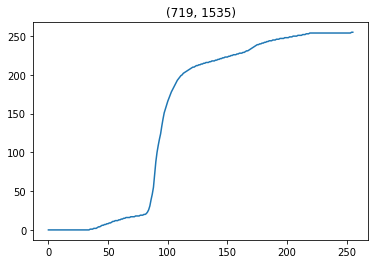

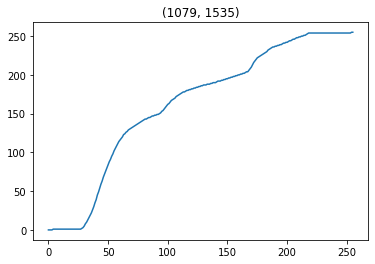

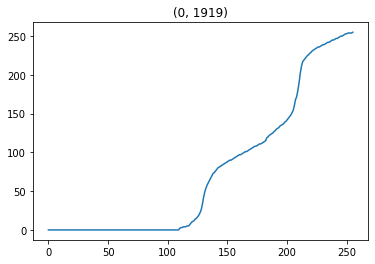

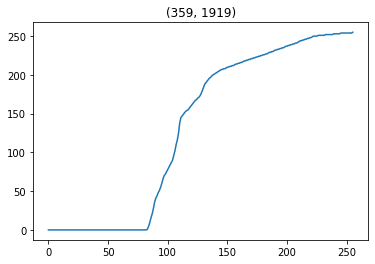

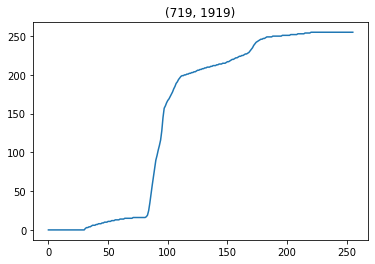

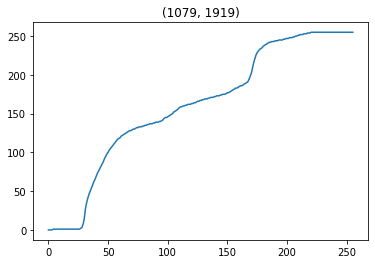

In [20]:
# show:
for key,value in vertice_cdf.items():
    plt.plot(np.arange(0,256,1),value)
    plt.title(key)
    plt.show()

#### Q4: (Optional) Use low-pass filtering of CDFs.
idea: **Moving average or box filter**, **Gaussian filter** and **median filter** are all examples of low-pass kernels.<br>
And a effective low-pass filter is `[−1/8, 1/4, 3/4, 1/4, −1/8]`.<br>
So I apply all filters mentioned above to the img and choose **Gaussian filter** eventually.

In [21]:
def effective_filter(array):
    a = copy.deepcopy(array)
    b = copy.deepcopy(array)
    a.resize(5,1)
    b.resize(1,5)
    c = np.mat(a)*np.mat(b)
    return c

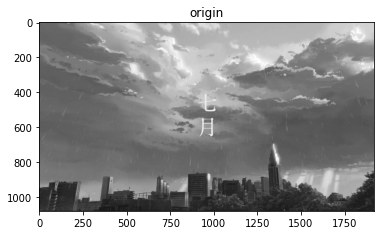

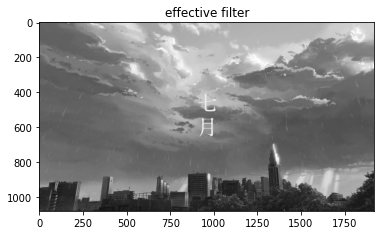

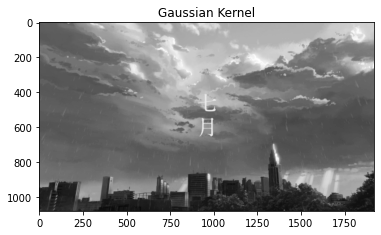

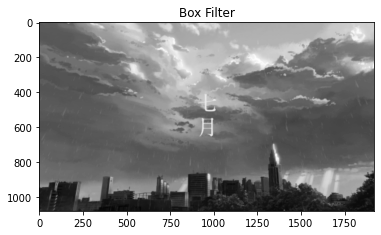

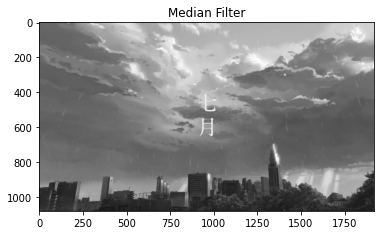

In [22]:
# 4. Use low-pass filtering of CDFs
# the effective low-pass filter is [-1/8,1/4,3/4,1/4,-1/8]
eff_kernel = effective_filter(np.array((-1/8,1/4,3/4,1/4,-1/8)))
effect_filter = cv2.filter2D(img_gray,-1,eff_kernel)
# GaussianKernel
Gauss_filter = cv2.GaussianBlur(img_gray,(5,5),1)
# BoxFilter:
box_filter = cv2.boxFilter(img_gray,-1,(5,5),True)
# medianFilter:
median_filter = cv2.medianBlur(img_gray,5)
plt_show("origin",img_gray,cmap="gray")
plt_show("effective filter",effect_filter,cmap="gray")
plt_show("Gaussian Kernel",Gauss_filter,cmap="gray")
plt_show("Box Filter",box_filter,cmap="gray")
plt_show("Median Filter",median_filter,cmap="gray")

Since the img I choose before can't show the differences between the filtering results.<br>
So let's load another img to have a try.

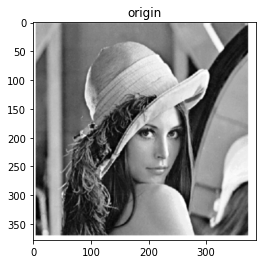

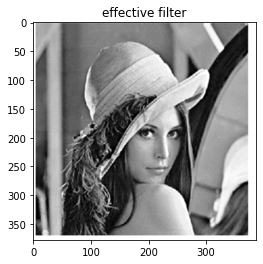

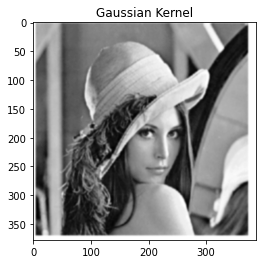

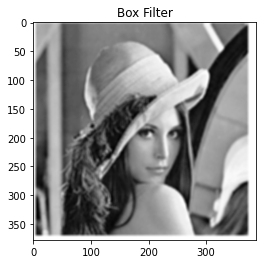

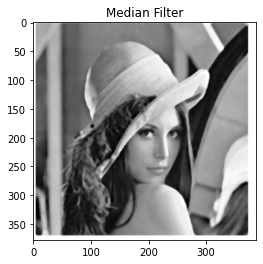

In [23]:
filter_img = cv2.imread('Gau.png')
gau_img = cv2.cvtColor(filter_img,cv2.COLOR_BGR2GRAY)
effect_filter_gau = cv2.filter2D(gau_img,-1,eff_kernel)
# GaussianKernel
Gauss_filter_gau = cv2.GaussianBlur(gau_img,(5,5),1)
# BoxFilter:
box_filter_gau = cv2.boxFilter(gau_img,-1,(5,5),True)
# medianFilter:
median_filter_gau = cv2.medianBlur(gau_img,5)
plt_show("origin",gau_img,cmap="gray")
plt_show("effective filter",effect_filter_gau,cmap="gray")
plt_show("Gaussian Kernel",Gauss_filter_gau,cmap="gray")
plt_show("Box Filter",box_filter_gau,cmap="gray")
plt_show("Median Filter",median_filter_gau,cmap="gray")

In [24]:
# Re-distribute:
lowpass_hist = vertice_init()
lowpass_hist = distribute_fun(Gauss_filter,lowpass_hist)
# Re-compute CDF:
lowpass_cdf = block_cdf_fun(lowpass_hist)

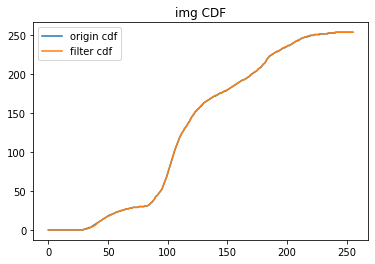

In [25]:
# filter img gray cdf:
filter_hist = Histogram(Gauss_filter)
filter_cdf_r = CDF(filter_hist[0])*255
filter_cdf_r[filter_cdf_r>255]=255
filter_cdf_r = filter_cdf_r.astype('uint8')
origin_cdf = CDF(hist[0])*255
origin_cdf[origin_cdf>255]=255
origin_cdf = origin_cdf.astype('uint8')
# show:
plt.plot(np.arange(0,256,1),origin_cdf,label = "origin cdf")
plt.plot(np.arange(0,256,1),filter_cdf_r,label = "filter cdf")
plt.title("img CDF")
plt.legend()
plt.show()

#### Q5: Interpolate adjacent CDFs for final lookup.
idea: The whole process is just the same as distribution above. <br>
Use the bilinear blending function:<br>
`f(I) = (1-s)(1-t)*f_00(I)+s(1-t)*f_10(I)+(1-s)t*f_01(I)+st*f_11(I)`

In [26]:
# 5. Interpolate adjacent CDFs for final lookup
def interpolate(img_gray,vertice_cdf):
    img_trans = np.zeros((img_gray.shape))
    for i in range(0,img_gray.shape[0]):
        for j in range(0,img_gray.shape[1]):
            index_i = i//window_size[0]
            index_j = j//window_size[1]
            # 左上角的坐标
            upleft_x = X_boudary[index_i]
            upleft_y = Y_boudary[index_j]
            # 右上角坐标：
            upright_x = X_boudary[index_i+1]
            # 左下角坐标：
            downleft_y = Y_boudary[index_j+1]

            # s,t computed：
            s,t = 0,0
            s = abs((i-upleft_x)/ (upright_x-upleft_x))
            t = abs((j-upleft_y)/(downleft_y-upleft_y))
            
            # interpolate with lookup functions:
            luma = img_gray[i,j]
            # upleft: (1-s)*(1-t)
            ul = vertice_cdf.get((upleft_x,upleft_y))[luma]*(1-s)*(1-t)
            # upright:s*(1-t)
            ur = vertice_cdf.get((upright_x,upleft_y))[luma]*s*(1-t)
            # downleft:(1-s)*t
            dl = vertice_cdf.get((upleft_x,downleft_y))[luma]*(1-s)*t
            # downright:s*t
            dr = vertice_cdf.get((upright_x,downleft_y))[luma]*s*t
            sum = ul+ur+dl+dr
            if sum>255:
                sum = 255
            img_trans[i][j] = sum.astype('uint8')
    return img_trans

It' happy to find that the **clarity** of gray img through **Local histogram equalization** is better than the origin gray img. <br>
And the distinction between the img through **Local histogram equalization** and the img through **Normal histogram equalization** is obvious.

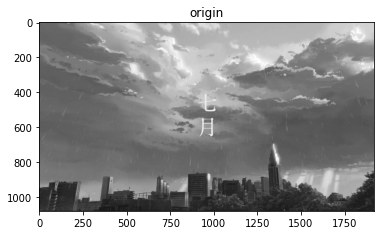

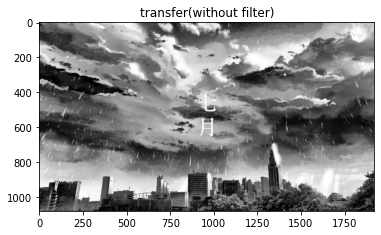

In [27]:
# without low-pass filter:
img_trans = interpolate(img_gray,vertice_cdf)
# show:
plt_show("origin",img_gray,cmap="gray")
plt_show("transfer(without filter)",img_trans,cmap="gray")

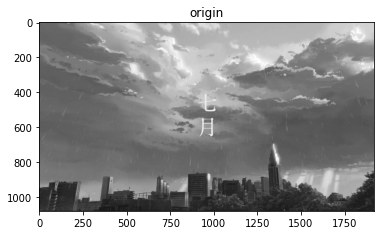

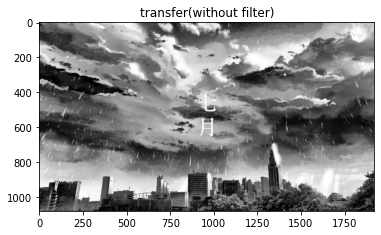

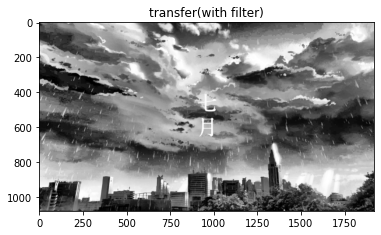

In [28]:
# with low-pass filter
img_filter_trans = interpolate(Gauss_filter,lowpass_cdf)
plt_show("origin",img_gray,cmap="gray")
plt_show("transfer(without filter)",img_trans,cmap="gray")
plt_show("transfer(with filter)",img_filter_trans,cmap="gray")

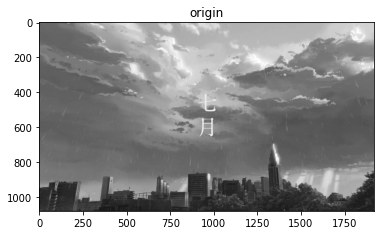

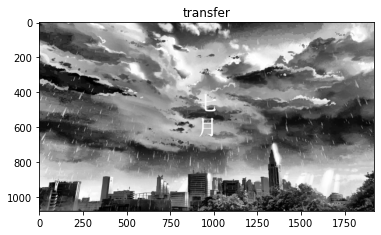

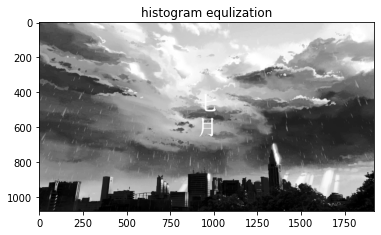

In [29]:
# Compare with histogram equalization:
img_histtrans = np.zeros((img_gray.shape))
for i in range(img_gray.shape[0]):
    for j in range(img_gray.shape[1]):
        img_histtrans[i][j] = origin_cdf[img_gray[i][j]]
img_histtrans[img_histtrans>255] = 255
img_histtrans.astype('uint8')

plt_show("origin",img_gray,cmap="gray")
plt_show("transfer",img_trans,cmap="gray")
plt_show("histogram equlization",img_histtrans,cmap="gray")